In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
tf.config.run_functions_eagerly(True)


In [3]:
!pip install transformers

In [4]:

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import transformers
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt


In [5]:
try:
   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
   print('Running on TPU ', tpu.master())
except ValueError:
   tpu = None
 
if tpu:
   tf.config.experimental_connect_to_cluster(tpu)
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.TPUStrategy(tpu)
else:
   strategy = tf.distribute.get_strategy()

In [6]:
trainset=pd.read_csv('train.csv')
testset=pd.read_csv('test.csv')

In [7]:
trainset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
trainset.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
testset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
trainset.value_counts('target')

target
0    4342
1    3271
dtype: int64

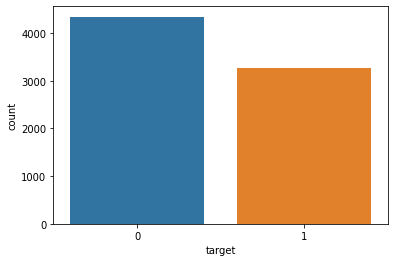

In [11]:
ax = sns.countplot(x="target", data=trainset)

Words in tweet

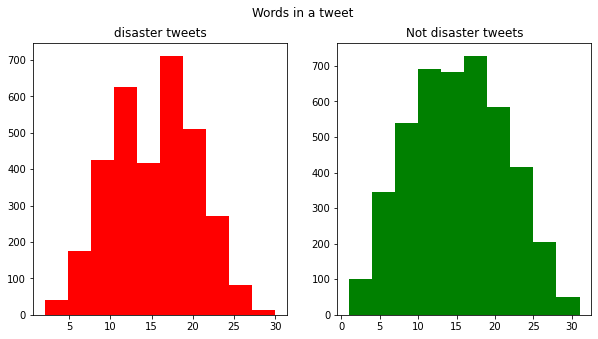

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=trainset[trainset['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=trainset[trainset['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Location Column

In [13]:
trainset.value_counts('location')

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Length: 3341, dtype: int64

In [14]:
#unique locations
print(trainset.location.nunique())

3341


In [15]:
print(testset.location.nunique())

1602


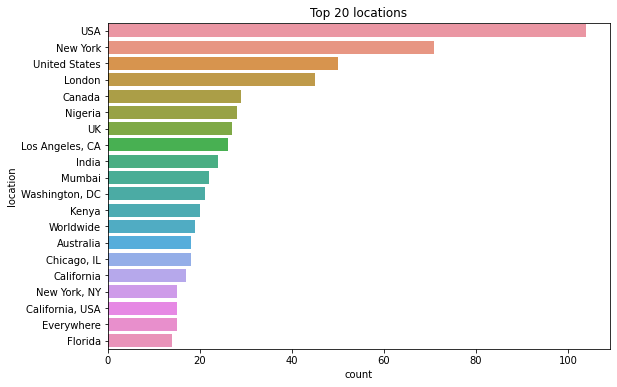

In [16]:
# Most common locations appearing in the tweets in the train set
plt.figure(figsize=(9,6))
sns.countplot(y=trainset.location, order = trainset.location.value_counts().iloc[:20].index)
plt.title('Top 20 locations')
plt.show()

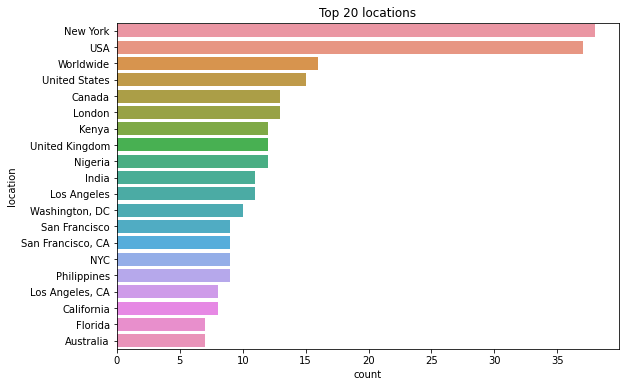

In [17]:
# Most common locations appearing in the tweets in the test set
plt.figure(figsize=(9,6))
sns.countplot(y=testset.location, order = testset.location.value_counts().iloc[:20].index)
plt.title('Top 20 locations')
plt.show()

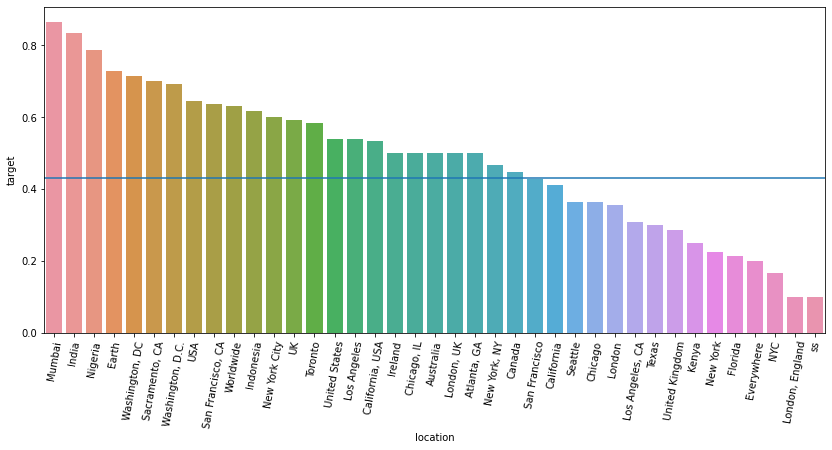

In [18]:
# % of disaster tweets for the common locations
raw_loc = trainset.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = trainset[trainset.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(trainset.target))
plt.xticks(rotation=80)
plt.show()

In [19]:
trainset.value_counts('keyword')

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Length: 221, dtype: int64

In [20]:
testset.value_counts('keyword')

keyword
deluged               23
rubble                22
demolished            22
first%20responders    21
obliteration          21
                      ..
forest%20fire          5
threat                 5
fatalities             5
inundation             4
epicentre              1
Length: 221, dtype: int64

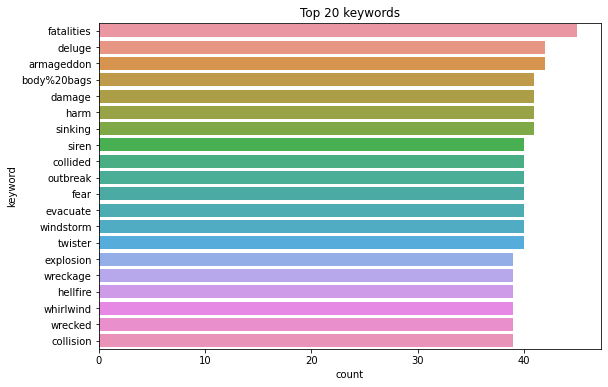

In [21]:
# Most common keywords appearing in the tweets in the train set
plt.figure(figsize=(9,6))
sns.countplot(y=trainset.keyword, order = trainset.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

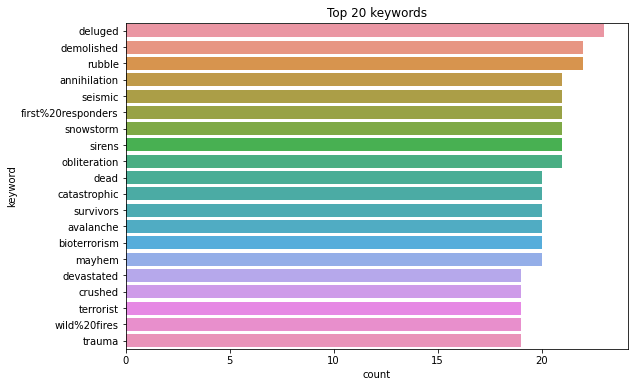

In [22]:
# Most common keywords appearing in the tweets in the test set
plt.figure(figsize=(9,6))
sns.countplot(y=testset.keyword, order = testset.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

In [23]:
trainset.drop(['id','location','keyword'], axis = 1,inplace=True)
testset.drop(['id','location','keyword'], axis = 1,inplace=True)

In [24]:
trainset.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Cleaning Data:Install the clean-text package for cleaning the tweets data. The tweets may contain urls, numbers, etc., which are not useful to us in our model development. The clean-text package allows an easy removal of such items.

In [25]:
!pip install clean-text[gpl]
 
from cleantext import clean

In [26]:
#We define a function for cleaning an input text with several configurable parameters.
def text_cleaning(text):
   text=clean(text,
     fix_unicode=True,               # fix various unicode errors
     to_ascii=True,                 # transliterate to closest ASCII representation
     lower=True,                    # lowercase text
     no_line_breaks=True,           # fully strip line breaks
     no_urls=True,                  # replace all URLs with ''
     no_emails=True,                # replace all email addresses with ''
     no_phone_numbers=True,         # replace all phone numbers with ''
     no_numbers=True,               # replace all numbers with ''
     no_digits=True,                # replace all digits with ''
     no_currency_symbols=True,      # replace all currency symbols with ''
     no_punct=True,                 # fully remove punctuation
     replace_with_url="",
     replace_with_email="",
     replace_with_phone_number="",
     replace_with_number="",
     replace_with_digit="",
     replace_with_currency_symbol="",
     lang="en"                      # set to 'en' for English
   )
   return text

In [27]:
for i in range(len(trainset)):
   trainset['text'].iloc[i]=text_cleaning(trainset['text'].iloc[i])
for i in range(len(testset)):
   testset['text'].iloc[i]=text_cleaning(testset['text'].iloc[i])   

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Removing stopwords

In [28]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stoplist = stopwords.words('english')
for i in range(len(trainset)):
  trainset['text'].iloc[i] = [word for word in trainset['text'].iloc[i].split() if word not in stoplist]
for i in range(len(testset)):
  testset['text'].iloc[i] = [word for word in testset['text'].iloc[i].split() if word not in stoplist]  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [29]:
trainset.head()

,text,target
0,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, asked, shelter, place, notified, o...",1
3,"[people, receive, wildfires, evacuation, order...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


most common words found in the tweets

In [30]:
# empty list for holding words from each row of trainset['text']
text_combined=[]
#Making a combined list of all the words from each tweet.
for i in range(len(trainset)):
 text_combined.append(trainset['text'].iloc[i])
#Making a combined list of all the words from each tweet.
from itertools import chain
flatten_list_text = list(chain.from_iterable(text_combined)) 

In [31]:
#Count instances of each word using collections.
import collections
word_counters = collections.Counter(flatten_list_text)
#Make a dataframe with words and their corresponding counts.
words_with_counts = pd.DataFrame(word_counters.most_common(15), columns=['words', 'count'])

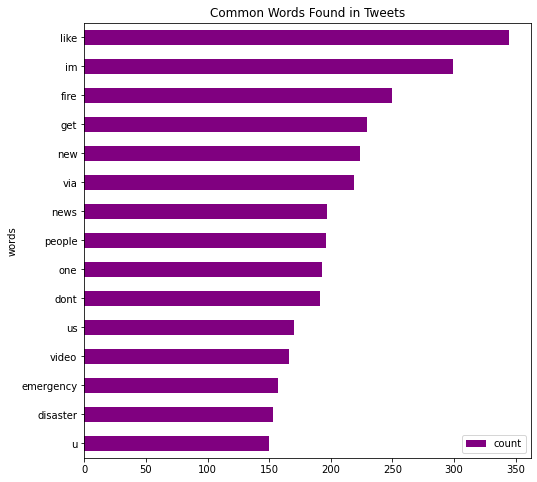

In [32]:
#We will first sort the words in decreasing order of their instances and then plot the most occurring words using matplotlib.
fig, ax = plt.subplots(figsize=(8, 8))
 
# Plot horizontal bar graph
# plot the frequency distribution after sorting
words_with_counts.sort_values(by='count').plot.barh(x='words', 
                     y='count',
                     ax=ax,
                     color="purple")
 
ax.set_title("Common Words Found in Tweets")
 
plt.show()

We will now feed this cleaned-up data to a BERT model for Natural Language Modeling.

In [33]:
#We will write our neural network model where the first layer will be the pre-trained BERT model followed by our own network layers.
def build_model(transformer, max_len=512):
   input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
   sequence_output = transformer(input_word_ids)[0]
   cls_token = sequence_output[:, 0, :]
   x = tf.keras.layers.Dropout(0.35)(cls_token)
 
   # make output dense layer
   out = Dense(1, activation='sigmoid')(x)
  
   model = Model(inputs=input_word_ids, outputs=out)
   model.compile(Adam(lr=3e-5), loss='binary_crossentropy',
                 metrics=[tf.keras.metrics.AUC()])
  
   return model
#In the above model, the transformer output is passed through a dropout to take care of overfitting, if any. 
#We then pass the output through a dense layer with sigmoid activation.
#We create a model using the Model function with the appropriate parameter values for inputs and outputs as defined above. 
#We compile the model with Adam optimizer and binary cross entropy loss function.   

In [34]:
#We use the bert-based-uncased pretrained model and pass it our above written build_model function for constructing our model.
with strategy.scope():
   transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
   model = build_model(transformer_layer, max_len=51)
model.summary()   

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 51)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


Data Preprocessing

In [35]:
#We first tokenize all our input datasets - training and testing. 
#You will use the BERT pre-trained tokenizer for this purpose. You create a tokenizer instance using the following statement:
import transformers
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [36]:
#Save the loaded tokenizer to your local environment.
import os
save_path = 'distilbert_base_uncased/'
if not os.path.exists(save_path):
   os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('distilbert_base_uncased/tokenizer_config.json',
 'distilbert_base_uncased/special_tokens_map.json',
 'distilbert_base_uncased/vocab.txt',
 'distilbert_base_uncased/added_tokens.json')

In [37]:
#Reload it with the Hugging Face tokenizers library.
from tokenizers import BertWordPieceTokenizer
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [38]:
#You will be using this fast_tokenizer to encode our input. 
#Next, we write an encode function that uses the above tokenizer for encoding the given text.
def fast_encode(texts, tokenizer, size=256, maxlen=512):
   tokenizer.enable_truncation(max_length=maxlen)  # truncate the text and limit it to maxlen
   tokenizer.enable_padding(length=maxlen)         # pad sentences shorter than maxlen
   ids_full = []
  
   for i in tqdm(range(0, len(texts), size)):
       text = texts[i:i+size].tolist()
       encs = tokenizer.encode_batch(text)        
       ids_full.extend([enc.ids for enc in encs])
  
   return np.array(ids_full)

The fast_encode encodes the text to numbers so that it can be used for model training. Typically, it is used for getting tokens, token types, and attention masks. It outputs a dictionary of encoded text. We now use this encode function to encode our training and testing datasets.

In [52]:
x = fast_encode(trainset.text.astype(str), fast_tokenizer, maxlen=51)
x1 = fast_encode(testset.text.astype(str), fast_tokenizer, maxlen=51)

Preparing Datasets

In [53]:
#We prepare the dataset for training by creating batches of data using:
tf.data.Dataset

BATCH_SIZE=32

y=trainset['target'].values

In [55]:
#We reserve 10% data for testing:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.1, random_state=42)

In [56]:
#We create the training dataset using the following statement. The AUTOTUNE parameter prepares the next batch of data while processing the current one.
train_dataset = (
   tf.data.Dataset
     .from_tensor_slices((X_train, y_train))
     .repeat()
     .shuffle(2048)
     .batch(BATCH_SIZE)
   .prefetch(tf.data.experimental.AUTOTUNE)
)

In [57]:
test_data = (
   tf.data.Dataset
   .from_tensor_slices(X_test)
   .batch(BATCH_SIZE)
)

Model Training

In [60]:
#We train the model by calling its fit method. 
#The strategy decides on the distribution strategy on the TPU cluster during training
with strategy.scope():
   train_history = model.fit(
     train_dataset,
     steps_per_epoch=10,
     epochs = 10
   )

Epoch 1/10
10/10 [==============================] - 118s 12s/step - loss: 0.6466 - auc: 0.6260
Epoch 2/10
10/10 [==============================] - 119s 12s/step - loss: 0.5707 - auc: 0.7534
Epoch 3/10
10/10 [==============================] - 118s 12s/step - loss: 0.5340 - auc: 0.8091
Epoch 4/10
10/10 [==============================] - 118s 12s/step - loss: 0.4676 - auc: 0.8496
Epoch 5/10
10/10 [==============================] - 118s 12s/step - loss: 0.5286 - auc: 0.8070
Epoch 6/10
10/10 [==============================] - 118s 12s/step - loss: 0.4751 - auc: 0.8623
Epoch 7/10
10/10 [==============================] - 118s 12s/step - loss: 0.4382 - auc: 0.8759
Epoch 8/10
10/10 [==============================] - 118s 12s/step - loss: 0.4462 - auc: 0.8630
Epoch 9/10
10/10 [==============================] - 118s 12s/step - loss: 0.4445 - auc: 0.8639
Epoch 10/10
10/10 [==============================] - 118s 12s/step - loss: 0.4060 - auc: 0.8810


In [61]:
predictions = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [62]:
#We flatten the predictions from 2-dim to a 1-dimensional arra
flattened_predictions = list(chain.from_iterable(predictions))

In [63]:
#We convert the predictions to '0' (non-disaster) or '1' (disaster) using a simple if condition
for i in range(len(flattened_predictions)):
 if flattened_predictions[i] <= 0.5:
   flattened_predictions[i] = 0
 else:
   flattened_predictions[i] = 1

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, flattened_predictions)

0.8097112860892388

In [65]:
predictions = model.predict(x1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [66]:
flattened_predictions1 = list(chain.from_iterable(predictions))

In [67]:
#We convert the predictions to '0' (non-disaster) or '1' (disaster) using a simple if condition
for i in range(len(flattened_predictions1)):
 if flattened_predictions1[i] <= 0.5:
   flattened_predictions1[i] = 0
 else:
   flattened_predictions1[i] = 1

In [69]:
result_data = pd.read_csv("sample_submission.csv")
output = pd.DataFrame({'id': result_data.id, 'target': flattened_predictions1})
output.to_csv('my_submission_bert.csv', index=False)